In [1]:
import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
import riemann
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['lines.markeredgewidth'] = 0.5
matplotlib.rcParams['lines.markersize'] = 8

This jupyter notebook contains functions, programs and plots for **APC 523 Lecture 23 on Advanced Hyperbolic Solvers** (copyright Romain Teyssier, Princeton University). 


In [2]:
gamma = 1.4

In [3]:
def prim_to_cons(w):
    u = 0.*w
    # density
    u[0] = w[0]
    # momentum
    u[1] = w[0]*w[1]
    # total energy
    u[2] = 0.5*w[0]*w[1]**2 + w[2]/(gamma-1)
    return u

In [4]:
def prim_to_flux(w):
    f = 0.*w
    # mass flux
    f[0] = w[0]*w[1]
    # momentum flux
    f[1] = w[0]*w[1]**2+w[2]
    # total energy flux
    f[2] = (0.5*w[0]*w[1]**2 + gamma*w[2]/(gamma-1))*w[1]
    return f

In [5]:
def cons_to_prim(u):
    w = 0.*u
    # density
    w[0] = u[0]
    # velocity
    w[1] = u[1]/u[0]
    # pressure
    w[2] = (gamma-1)*(u[2]-0.5*w[0]*w[1]**2)
    return w

In [6]:
def set_ic(x, ic_type = "sod test"):
    n = x.size
    d = np.zeros(n)
    v = np.zeros(n)
    p = np.zeros(n)
    if ic_type == "sod test":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = 0
                p[i] = 1
            else:
                d[i] = 0.125
                v[i] = 0
                p[i] = 0.1
    elif ic_type == "toro test1":
        for i in range(0,n):
            if (x[i] < 0.3):
                d[i] = 1
                v[i] = 0.75
                p[i] = 1
            else:
                d[i] = 0.125
                v[i] = 0
                p[i] = 0.1
    elif ic_type == "toro test2":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = -2
                p[i] = 0.4
            else:
                d[i] = 1
                v[i] = 2
                p[i] = 0.4
    elif ic_type == "toro test3":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = 0
                p[i] = 1000
            else:
                d[i] = 1
                v[i] = 0
                p[i] = 0.01
    elif ic_type == "shu osher":
        for i in range(0,n):
            if (x[i] < 0.125):
                d[i] = 3.857143
                v[i] = 2.629369
                p[i] = 10.33333
            else:
                d[i] = 1+0.2*np.sin(2*np.pi*8*x[i])
                v[i] = 0
                p[i] = 1
    else:
        print("Unkown IC type=",ic_type)
    # convert to conservative variables
    w = np.reshape([d,v,p],(3,n))
    u = prim_to_cons(w)
    return u

In [7]:
def set_bc(u, type = "periodic"):
    if type == "periodic":
        u[:,0] = u[:,-4]
        u[:,1] = u[:,-3]
        u[:,-1] = u[:,3]
        u[:,-2] = u[:,2]
    elif type == "free":
        u[:,0] = u[:,2]
        u[:,1] = u[:,2]
        u[:,-1] = u[:,-3]
        u[:,-2] = u[:,-3]
    elif type == "wall":
        u[:,0] = u[:,3]
        u[:,1] = u[:,2]
        u[:,-1] = u[:,-4]
        u[:,-2] = u[:,-3]
        u[1,0] = -u[1,3]
        u[1,1] = -u[1,2]
        u[1,-1] = -u[1,-4]
        u[1,-2] = -u[1,-3]
    else:
        print("Unknow BC type")

In [8]:
def compute_slope(u, alpha, type = "minmod"):

    du=np.zeros([u.size-2])

    if type == "minmod":
        dlft = u[:,1:-1]-u[:,:-2]
        drgt = u[:,2:]-u[:,1:-1]
        dsgn = np.sign(dlft)
        dslp = dsgn*np.minimum(abs(dlft),abs(drgt))
        du = np.where(dlft*drgt<=0,0,dslp)

    elif type == "moncen":
        dlft = u[:,1:-1]-u[:,:-2]
        drgt = u[:,2:]-u[:,1:-1]
        dcen = 0.5*(dlft+drgt)
        dsgn = np.sign(dcen)
        dslp = dsgn*np.minimum(np.minimum(abs(2*dlft),abs(2*drgt)),abs(dcen))
        du = np.where(dlft*drgt<=0,0,dslp)

    elif type == "moncen2":
        alft = alpha[:,:-2]
        argt = alpha[:,2:]
        acen = alpha[:,1:-1]
        aslp = np.minimum(np.minimum(alft,argt),acen)
        dlft = u[:,1:-1]-u[:,:-2]
        drgt = u[:,2:]-u[:,1:-1]
        dcen = 0.5*(dlft+drgt)
        dsgn = np.sign(dcen)
        dslp = dsgn*np.minimum(np.minimum(abs(2*dlft),abs(2*drgt)),abs(dcen))
        du1 = np.where(dlft*drgt<=0,0,dslp)
        du = np.where(aslp<1,du1,dcen)

    elif type == "nolim":
        du = 0.5*(u[:,2:]-u[:,:-2])
    else: # first order godunov scheme
        du = 0.0*(u[:,2:]-u[:,:-2])

    return du

In [9]:
def smooth_extrema(u,bc_type):
    
    # compute central first derivative
    du = 0.5*(u[:,2:]-u[:,:-2])
    uprime = np.pad(du,[(0,0),(1,1)])
    set_bc(uprime,bc_type)
    
    # compute left, right and central second derivative
    dlft = uprime[:,1:-1]-uprime[:,:-2]
    drgt = uprime[:,2:]-uprime[:,1:-1]
    dmid = 0.5*(dlft+drgt)
    
    # detect discontinuity on the left (alpha_left<1)
    with np.errstate(divide='ignore', invalid='ignore'):
        alfp = np.minimum(1,np.maximum(2*dlft,0)/dmid)
        alfm = np.minimum(1,np.minimum(2*dlft,0)/dmid)
    alfl = np.where(dmid>0,alfp,alfm)
    alfl = np.where(dmid==0,1,alfl)
    
    # detect discontinuity on the right (alpha_right<1)
    with np.errstate(divide='ignore', invalid='ignore'):
        alfp = np.minimum(1,np.maximum(2*drgt,0)/dmid)
        alfm = np.minimum(1,np.minimum(2*drgt,0)/dmid)
    alfr = np.where(dmid>0,alfp,alfm)
    alfr = np.where(dmid==0,1,alfr)
    
    # finalize smooth extrema marker (alpha=1)
    alf = np.minimum(alfl,alfr)
    alpha = np.pad(alf,[(0,0),(1,1)])
    set_bc(alpha,bc_type)
        
    return alpha

In [10]:
def muscl(tend = 1, n = 100, ic_type = "sod test", bc_type = "periodic", riemann_solver="llf", slp_type = "moncen"):

    # set run parameters
    h = 1/n
    nitermax = 100000
    print("cell=", n, " itermax=", nitermax)

    # set grid geometry
    xf = np.linspace(0,1,n+1)
    x = 0.5*(xf[1:]+xf[:-1])
    
    # allocate permanent storage
    u = np.zeros([nitermax+1,3,n])

    # set initial conditions
    u[0] = set_ic(x,ic_type=ic_type)
    
    # allocate temporary workspace
    uold = np.zeros([3,n+4])     
    
    # init time and iteration counter
    t = 0
    niter = 1

    # main time loop
    while(t<tend and niter <= nitermax):
        
        uold[:,2:-2] = u[niter-1]     # copy old solution
        set_bc(uold,bc_type)          # set boundary conditions
        
        wold = cons_to_prim(uold)     # convert to primitive variables
        cold = np.sqrt(gamma*wold[2]/wold[0])  # compute sound speed
        dt = 0.8*h/max(abs(wold[1])+cold)        # compute time step
        
        alpha = smooth_extrema(wold,bc_type)       # compute smooth extrema detector
        dw = compute_slope(wold,alpha,slp_type)      # compute TVD slopes
        
        wcen = wold[:,1:-1]
        ds = 0.*dw
        
        ds[0] = -wcen[1]*dw[0] - wcen[0]*dw[1]    # compute predictor source term for density
        ds[1] = -wcen[1]*dw[1] - 1/wcen[0]*dw[2]     # compute predictor source term for velocity
        ds[2] = -wcen[1]*dw[2] - gamma*wcen[2]*dw[1]    # compute predictor source term for pressure

        wplus = wcen - dw/2 + ds*dt/2/h    # extrapolate to left interface
        wminus = wcen + dw/2 + ds*dt/2/h    # extrapolate to right interface
        
        wleft = wminus[:,:-1]       # left state for riemann problem
        wright = wplus[:,1:]       # right state for riemann problem

        if(riemann_solver == 'llf'):
            flux = riemann.llf(wleft,wright)

        if(riemann_solver == 'hll'):
            flux = riemann.hll(wleft,wright)

        if(riemann_solver == 'hllc'):
            flux = riemann.hllc(wleft,wright)

        if(riemann_solver == 'exact'):
            flux = riemann.exact(wleft,wright)
                    
        uold[:,2:-2] = uold[:,2:-2]-dt/h*(flux[:,1:]-flux[:,:-1])   # update solution
        u[niter] = uold[:,2:-2]         # store new solution
        t = t+dt                  # update time
#        print(niter,t,dt)
        niter = niter+1       # update iteration counter

    print("Done ",niter-1,t)
    return u[0:niter]

In [11]:
u1=muscl(tend=0.245,n=100,ic_type="sod test",bc_type="free",riemann_solver="hllc",slp_type="moncen")
u2=muscl(tend=0.245,n=100,ic_type="sod test",bc_type="free",riemann_solver="hllc",slp_type="moncen2")

cell= 100  itermax= 100000
Done  67 0.2470931288273145
cell= 100  itermax= 100000
Done  67 0.24701220468899104


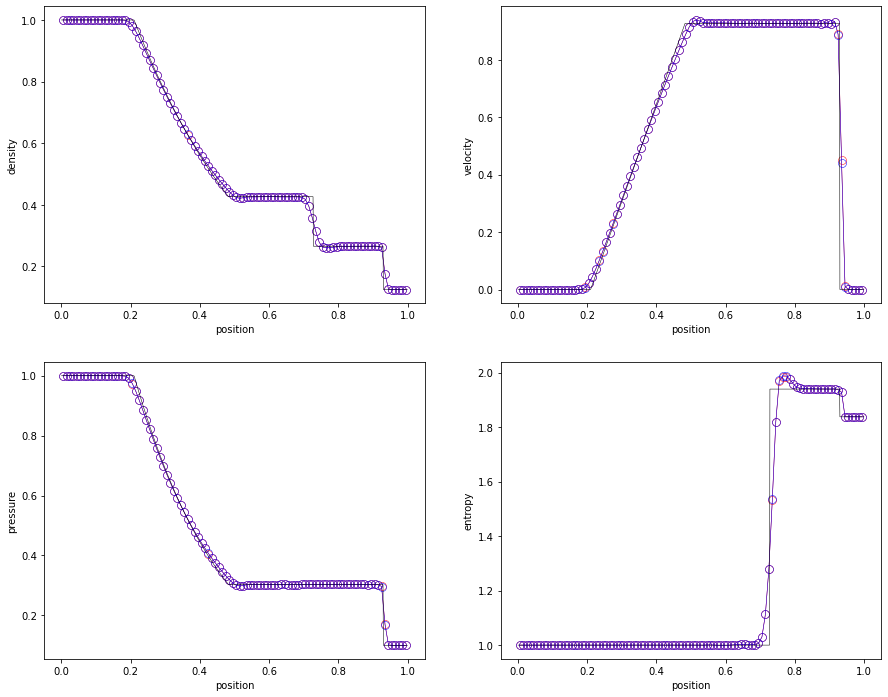

In [12]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.245
    d,v,p = riemann.exact_solution(s,[1,0,1],[0.125,0,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],'ro-',mfc='none')
ax1.plot(x1,w2[0,:],'bo-',mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],'ro-',mfc='none')
ax2.plot(x1,w2[1,:],'bo-',mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],'ro-',mfc='none')
ax3.plot(x1,w2[2,:],'bo-',mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,'ro-',mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,'bo-',mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")
plt.savefig('sod_test_muscl.png')

In [13]:
u1=muscl(tend=0.2,n=100,ic_type="toro test1",bc_type="free",riemann_solver="hllc",slp_type="zero")
u2=muscl(tend=0.2,n=100,ic_type="toro test1",bc_type="free",riemann_solver="hllc",slp_type="moncen2")

cell= 100  itermax= 100000
Done  67 0.20027533976989711
cell= 100  itermax= 100000
Done  69 0.20228316499107746


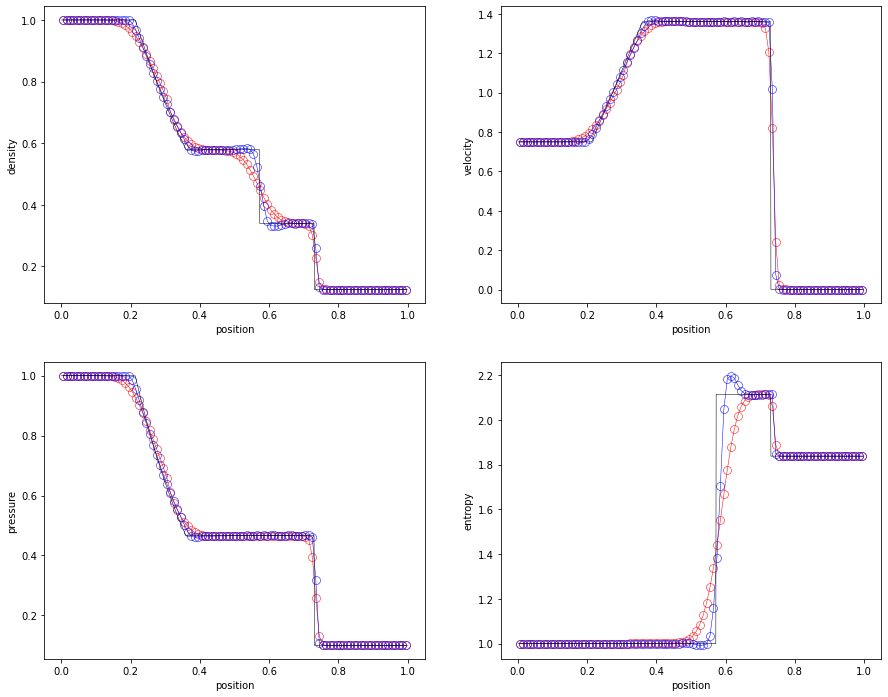

In [14]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.3)/0.2
    d,v,p = riemann.exact_solution(s,[1,0.75,1],[0.125,0,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],'ro-',mfc='none')
ax1.plot(x1,w2[0,:],'bo-',mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],'ro-',mfc='none')
ax2.plot(x1,w2[1,:],'bo-',mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],'ro-',mfc='none')
ax3.plot(x1,w2[2,:],'bo-',mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,'ro-',mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,'bo-',mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")

plt.savefig('toro_test1_muscl.png')

In [15]:
u1=muscl(tend=0.15,n=800,ic_type="toro test2",bc_type="free",riemann_solver="hllc",slp_type="zero")
u2=muscl(tend=0.15,n=800,ic_type="toro test2",bc_type="free",riemann_solver="hllc",slp_type="moncen2")

cell= 800  itermax= 100000
Done  413 0.15027299414316111
cell= 800  itermax= 100000
Done  413 0.15027299414316111


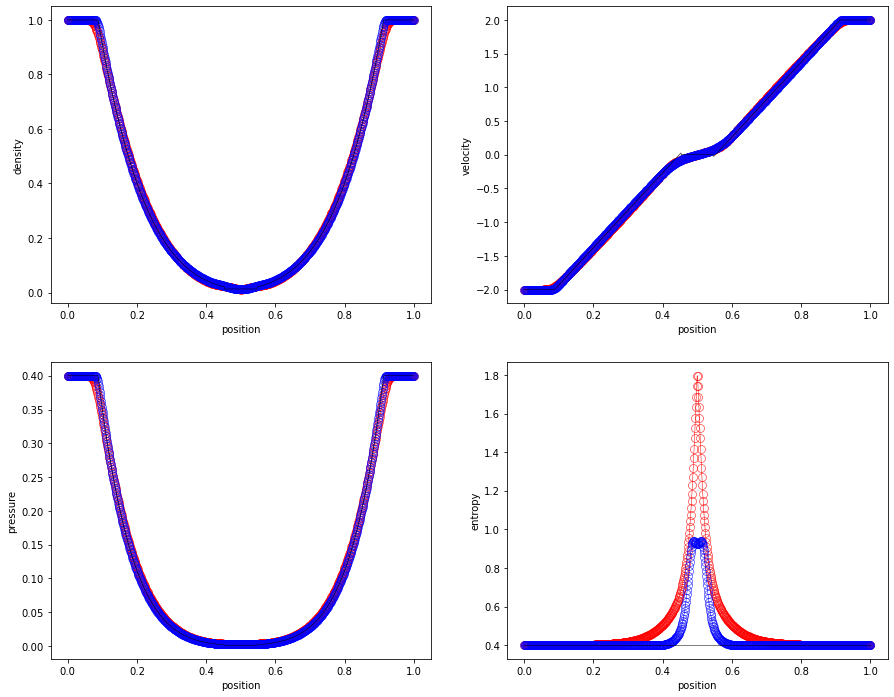

In [16]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.15
    d,v,p = riemann.exact_solution(s,[1,-2,0.4],[1,2,0.4])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],'ro-',mfc='none')
ax1.plot(x1,w2[0,:],'bo-',mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],'ro-',mfc='none')
ax2.plot(x1,w2[1,:],'bo-',mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],'ro-',mfc='none')
ax3.plot(x1,w2[2,:],'bo-',mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,'ro-',mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,'bo-',mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")
plt.savefig('toro_test2_muscl.png')

In [17]:
u1=muscl(tend=0.012,n=100,ic_type="toro test3",bc_type="free",riemann_solver="hllc",slp_type="zero")
u2=muscl(tend=0.012,n=100,ic_type="toro test3",bc_type="free",riemann_solver="hllc",slp_type="moncen2")

cell= 100  itermax= 100000
Done  80 0.012103405007493816
cell= 100  itermax= 100000
Done  81 0.012073595844235873


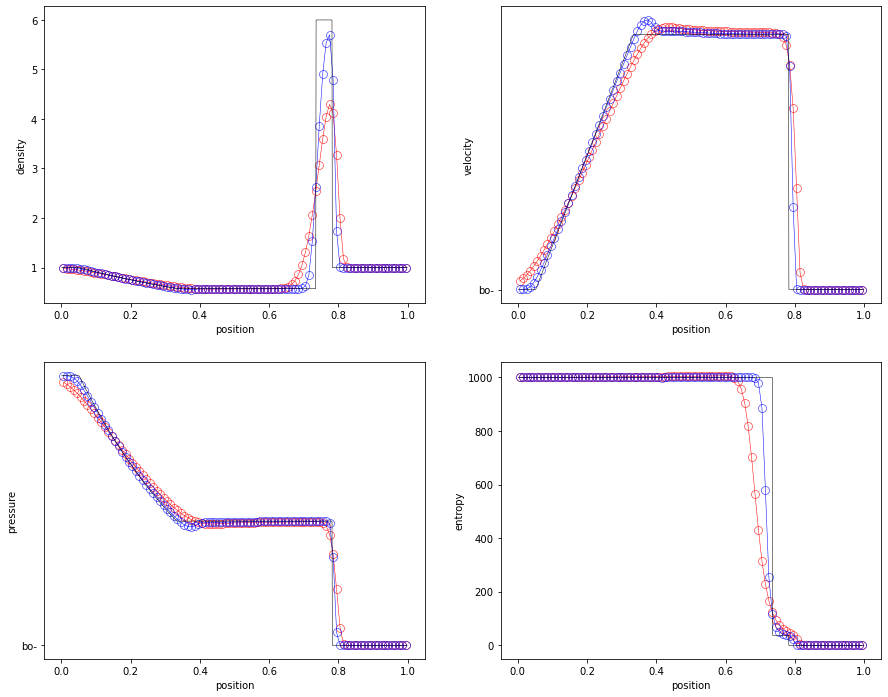

In [18]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.012
    d,v,p = riemann.exact_solution(s,[1,0,1000],[1,0,0.01])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],'ro-',mfc='none')
ax1.plot(x1,w2[0,:],'bo-',mfc='none')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],'ro-',mfc='none')
ax2.plot(x1,w2[1,:],"bo-",'bo-',mfc='none')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],'ro-',mfc='none')
ax3.plot(x1,w2[2,:],"bo-",'bo-',mfc='none')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,'ro-',mfc='none')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,'bo-',mfc='none')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")
plt.savefig('toro_test3_muscl.png')

In [19]:
u1=muscl(tend=0.245,n=128,ic_type="sod test",bc_type="free",riemann_solver="exact",slp_type="moncen2")
u2=muscl(tend=0.245,n=128,ic_type="sod test",bc_type="free",riemann_solver="llf",  slp_type="moncen2")
u3=muscl(tend=0.245,n=128,ic_type="sod test",bc_type="free",riemann_solver="hll",  slp_type="moncen2")
u4=muscl(tend=0.245,n=128,ic_type="sod test",bc_type="free",riemann_solver="hllc", slp_type="moncen2")

cell= 128  itermax= 100000
Done  86 0.2469253277627151
cell= 128  itermax= 100000
Done  86 0.24687856625625376
cell= 128  itermax= 100000
Done  86 0.247286573805123
cell= 128  itermax= 100000
Done  86 0.24689500206791992


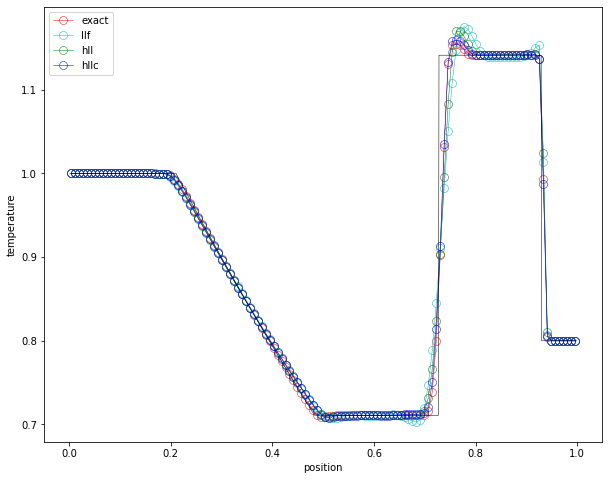

In [20]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])
w3 = cons_to_prim(u3[-1,:,:])
w4 = cons_to_prim(u4[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.245
    d,v,p = riemann.exact_solution(s,[1,0,1],[0.125,0.,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("temperature")
ax1.plot(x1,w1[2,:]/w1[0,:],'ro-',mfc='none',label="exact")
ax1.plot(x1,w2[2,:]/w2[0,:],'co-',mfc='none',label="llf")
ax1.plot(x1,w3[2,:]/w3[0,:],'go-',mfc='none',label="hll")
ax1.plot(x1,w4[2,:]/w4[0,:],'bo-',mfc='none',label="hllc")
ax1.plot(xana,wana[2,:]/wana[0,:],"k")

ax1.legend()

plt.savefig('riemann_comp_muscl.png')

In [25]:
gamma=1.4
uref=muscl(tend=0.178,n=10000,ic_type="shu osher",bc_type="free",riemann_solver="hllc",slp_type="moncen2")

cell= 10000  itermax= 100000
Done  10652 0.17800572827186414


In [26]:
u1=muscl(tend=0.178,n=400,ic_type="shu osher",bc_type="free",riemann_solver="hllc",slp_type="moncen2")

cell= 400  itermax= 100000
Done  424 0.1781334608638296


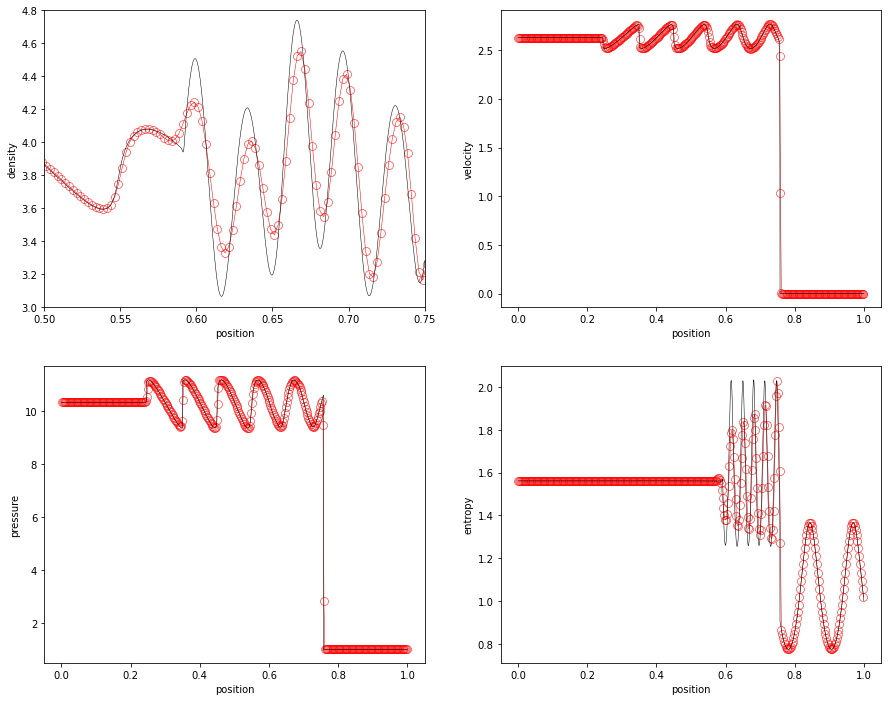

In [27]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])

xref = (np.arange(uref.shape[2])+0.5)/uref.shape[2]
wref = cons_to_prim(uref[-1,:,:])

ax1.set_xlabel("position")
ax1.set_ylabel("density")
ax1.set_xlim([0.5,0.75])
ax1.set_ylim([3,4.8])
ax1.plot(x1,w1[0,:],"ro-",mfc='none')
ax1.plot(xref,wref[0,:],"k-")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],"ro-",mfc='none')
ax2.plot(xref,wref[1,:],"k-")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],"ro-",mfc='none')
ax3.plot(xref,wref[2,:],"k-")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,"ro-",mfc='none')
ax4.plot(xref,wref[2,:]/wref[0,:]**gamma,"k-")